# Spotify Song Clustering with Unsupervised Learning

Understanding what makes songs similar — beyond genre labels or popularity — is a core challenge in modern music recommendation systems. Streaming platforms increasingly rely on audio-derived features such as energy, danceability, valence, and tempo to learn relationships between tracks and surface new music that aligns with listener preferences.

This project uses unsupervised learning to explore patterns in Spotify audio data and group songs based solely on their acoustic characteristics. By removing labels entirely and focusing only on numerical audio features, the goal is to uncover natural structure in the dataset and evaluate whether these learned clusters reflect meaningful musical differences.

---

## 1. Problem Description & Data Provenance

The dataset used here comes from the public Spotify Tracks Dataset (genres_v2), which contains audio features computed directly by Spotify’s analysis pipeline. 

The central guiding question:

**If we cluster songs using their audio features alone, do coherent musical groupings naturally emerge?**

To answer this, the notebook proceeds through data inspection, feature engineering, scaling, and multiple clustering methods.

---

## 2. Exploratory Data Analysis (EDA)

The EDA examines:

- Dataset structure and data types  
- Distributions of audio features  
- Correlations and redundancies  
- Outliers, missing values, and cleaning decisions  
- Scaling transformations needed for modeling  

This stage provides intuition about which features carry meaningful signal versus those that are highly correlated.

---

## 3. Unsupervised Learning Workflow

After preprocessing, the modeling steps include:

- Standardizing the feature space  
- Applying K-Means as a baseline clustering algorithm  
- Experimenting with different values of k  
- Exploring alternative methods (e.g., GMM, hierarchical clustering)  
- Using PCA for dimensionality reduction and visualization  

A focus throughout is cluster interpretability, not just cluster formation.

---

## 4. Results Overview

Clustering results are evaluated by interpreting the average feature profiles of each group and visualizing separation in lower-dimensional space. The analysis investigates whether clusters correspond to identifiable musical characteristics, such as energetic dance tracks versus softer acoustic songs.

<br>

In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
# Read data
data_path = "../data/genres_v2.csv"
df = pd.read_csv(data_path)
df.head()

C:\Users\Nick\AppData\Local\Temp\ipykernel_39788\702019918.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,audio_features,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,audio_features,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,audio_features,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,audio_features,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,audio_features,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


## 1. Problem Description & Data Provenance

The goal of this project is to use unsupervised learning to discover natural 
groupings of songs based on their audio characteristics. Modern music streaming 
platforms provide many numerical descriptors for each track—such as danceability, 
energy, valence, loudness, tempo, and acousticness—that capture meaningful aspects 
of how a song sounds. By applying clustering methods to these audio features, we 
aim to uncover latent structure in the dataset, identify different "vibes" or 
pseudo-genres, and analyze how these clusters relate to existing genre labels or 
artistic styles. This is an unsupervised learning problem because the dataset does 
not include a target variable and the goal is pattern discovery rather than prediction.

The dataset used in this project is `genres_v2.csv`, part of the *Dataset of Songs 
in Spotify* published on Kaggle by user **mrmorj** 
(https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify). The dataset 
contains more than 170,000 tracks with their audio features obtained via the 
Spotify Web API. Each row represents a single song and includes metadata 
(track name, artist, popularity, and genre) along with numerical audio attributes. 

The audio features include:

- Spectral qualities (e.g., acousticness, instrumentalness)
- Dynamic characteristics (e.g., loudness, energy)
- Temporal descriptors (e.g., tempo, duration_ms)
- Mood-related attributes (e.g., valence, danceability)

This section documents the origin and structure of the data for reproducibility. 
In the following sections, we conduct Exploratory Data Analysis (EDA), clean and 
transform the dataset, and apply multiple unsupervised learning methods—including 
K-Means clustering and dimensionality reduction—to explore the underlying structure 
of the songs.

### 2.1 Initial Data Inspection

In [4]:
# Shape of dataset
df.shape

(42305, 22)

In [5]:
# Columns
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'],
      dtype='object')

In [6]:
# Data types
df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
genre                object
song_name            object
Unnamed: 0          float64
title                object
dtype: object

In [7]:
df.isna().sum().sort_values(ascending=False)

Unnamed: 0          21525
title               21525
song_name           20786
key                     0
danceability            0
energy                  0
speechiness             0
mode                    0
loudness                0
acousticness            0
tempo                   0
instrumentalness        0
liveness                0
valence                 0
uri                     0
id                      0
type                    0
track_href              0
time_signature          0
duration_ms             0
analysis_url            0
genre                   0
dtype: int64

In [8]:
# Select only numerical audio features for EDA and clustering
audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
    'key', 'mode', 'time_signature'
]

df_audio = df[audio_features]

df_audio.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature
0,0.831,0.814,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,124539,2,1,4
1,0.719,0.493,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,224427,8,1,4
2,0.850,0.893,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,98821,5,1,4
3,0.476,0.781,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,123661,0,1,3
4,0.798,0.624,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,123298,2,1,4


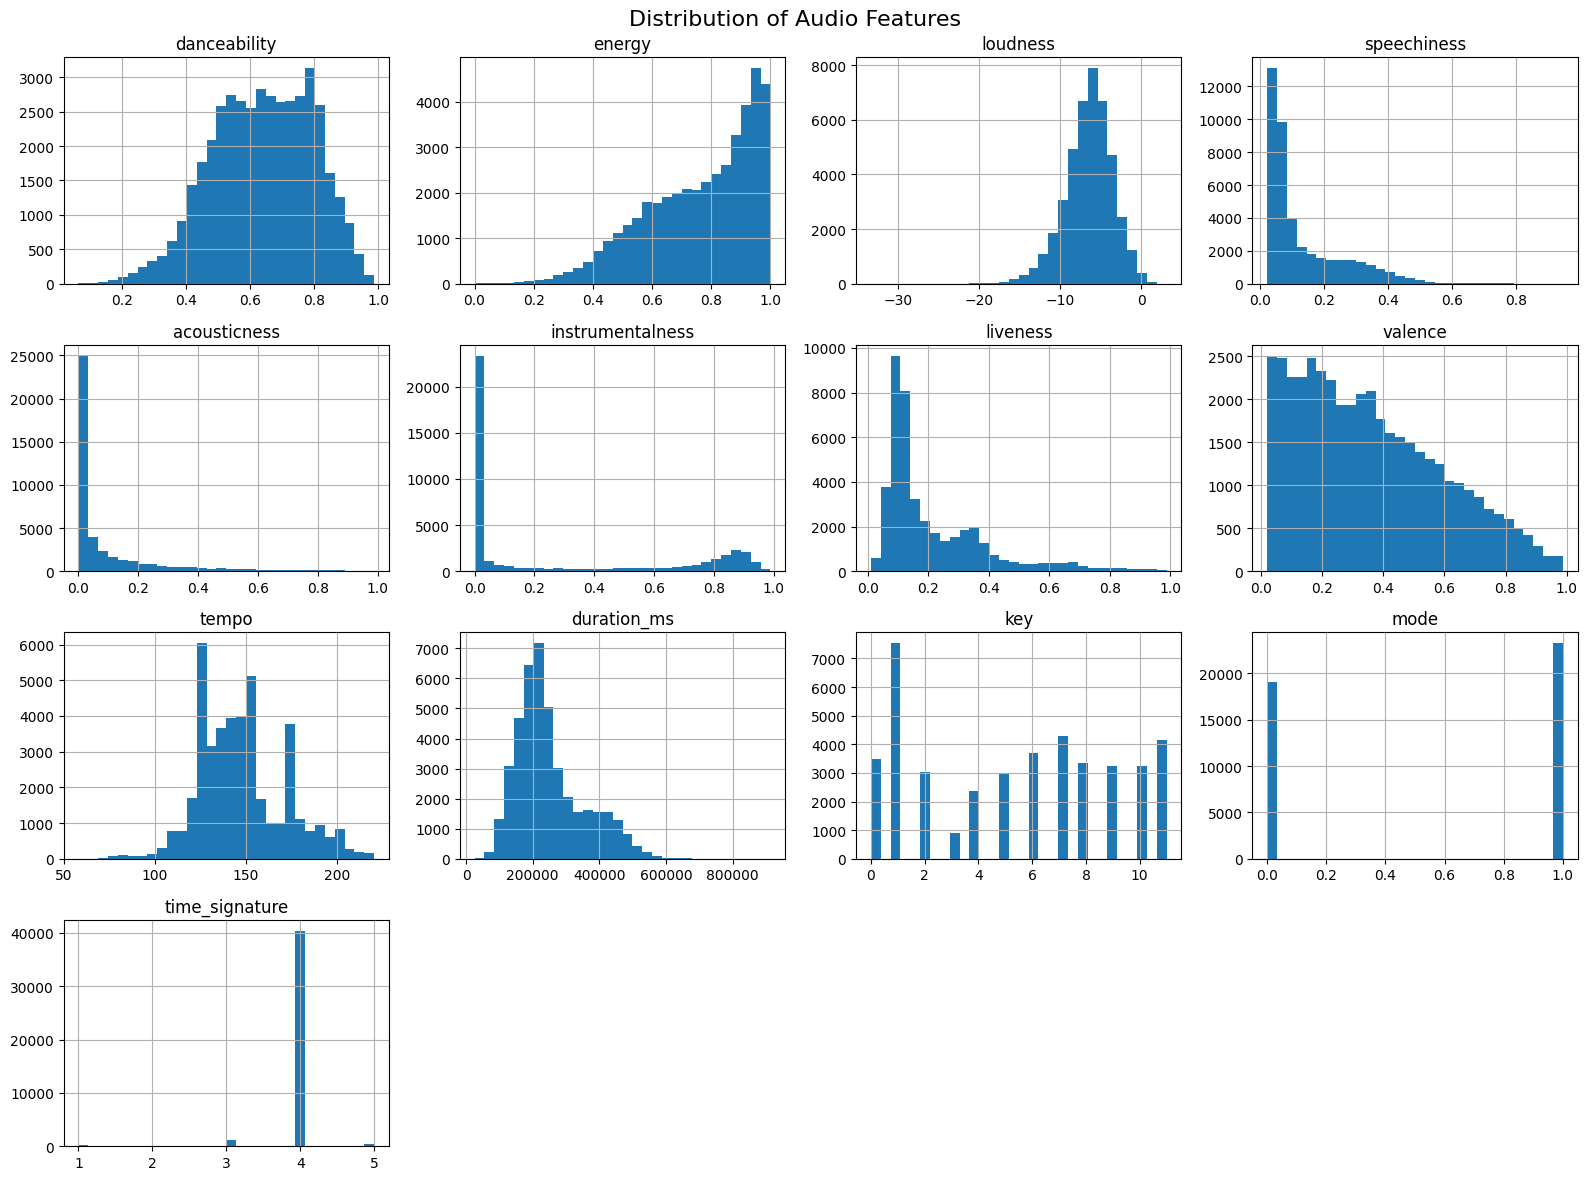

In [9]:
df_audio.hist(bins=30, figsize=(16, 12))
plt.suptitle("Distribution of Audio Features", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
# Features to use for clustering
model_features = [
    'danceability', 'energy', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'duration_ms'
]

df_model = df[model_features].copy()
df_model.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.831,0.814,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,124539
1,0.719,0.493,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,224427
2,0.850,0.893,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,98821
3,0.476,0.781,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,123661
4,0.798,0.624,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,123298


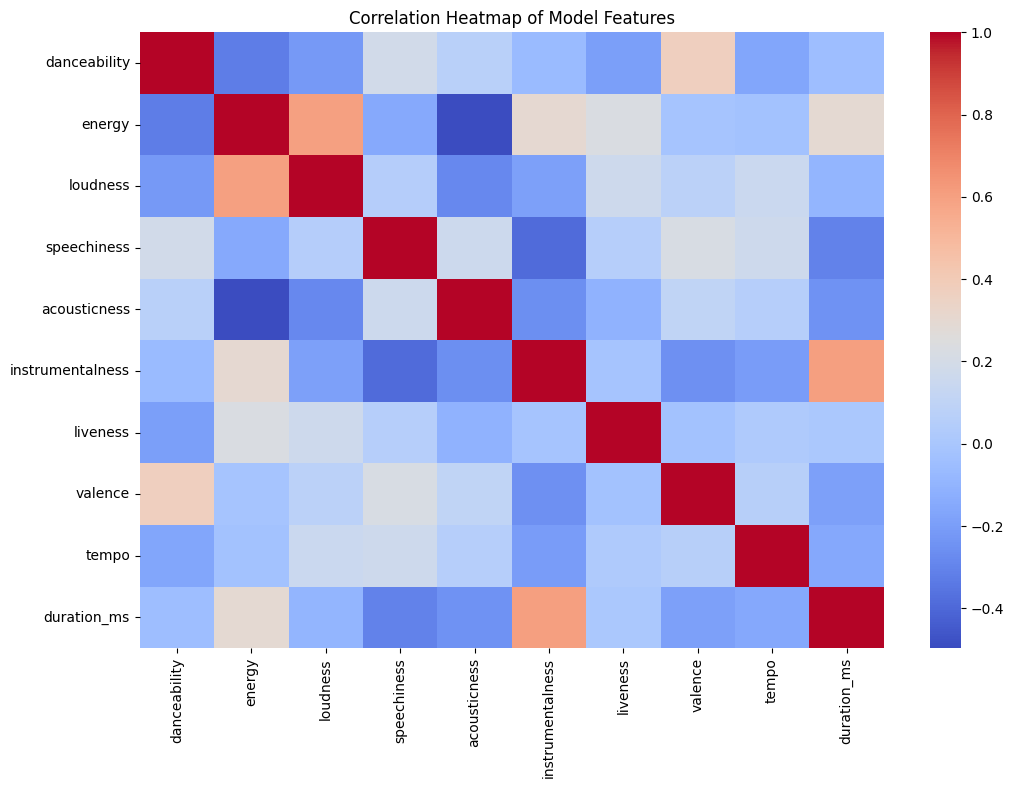

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_model.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap of Model Features")
plt.show()

### 2.3 Correlation Analysis Insights

The correlation heatmap reveals several meaningful relationships among the audio
features:

- **Energy and Loudness** are strongly positively correlated. This aligns with
  the expectation that songs with higher perceived energy tend to also be louder.
- **Acousticness and Energy** show a moderate negative correlation, indicating 
  that acoustic tracks are generally lower in intensity.
- **Instrumentalness** and **duration_ms** are moderately correlated; longer tracks 
  tend to contain more instrumental content (e.g., ambient or classical music).
- **Danceability and Valence** show a mild positive association, reflecting that 
  happier songs are often slightly more danceable.

None of the features exhibit extremely high correlations (>|0.9|), meaning there
is no evidence of redundant variables that should be removed. However, the 
presence of moderate correlations indicates that **PCA (Principal Component 
Analysis)** may help decorrelate the data and reveal dominant patterns in the 
feature space. PCA will also provide a useful low-dimensional representation for 
visualizing clusters.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model)

scaled_df = pd.DataFrame(scaled_data, columns=df_model.columns)
scaled_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1.223608,0.280079,-0.305514,2.246552,-0.212853,-0.727231,-0.902637,0.136790,0.398876,-1.226992
1,0.508480,-1.466185,-0.259954,-0.453057,1.784518,-0.763370,-0.547231,-0.999586,-1.358564,-0.256796
2,1.344924,0.709845,0.572039,-0.588592,-0.482135,-0.763359,0.899456,-1.363655,2.959861,-1.476787
3,-1.043093,0.100557,0.596860,-0.266002,-0.424181,-0.763370,-0.570013,-0.780887,1.655485,-1.235520
4,1.012900,-0.753535,-0.408876,1.239945,0.707390,-0.763370,-0.273841,1.003008,0.021554,-1.239046


In [13]:
from sklearn.decomposition import PCA

# Fit PCA with all components for analysis
pca = PCA()
pca_fit = pca.fit(scaled_df)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.25909067, 0.19198097, 0.12894952, 0.09305474, 0.08453634,
       0.07282089, 0.06339932, 0.04662013, 0.03888105, 0.02066637])

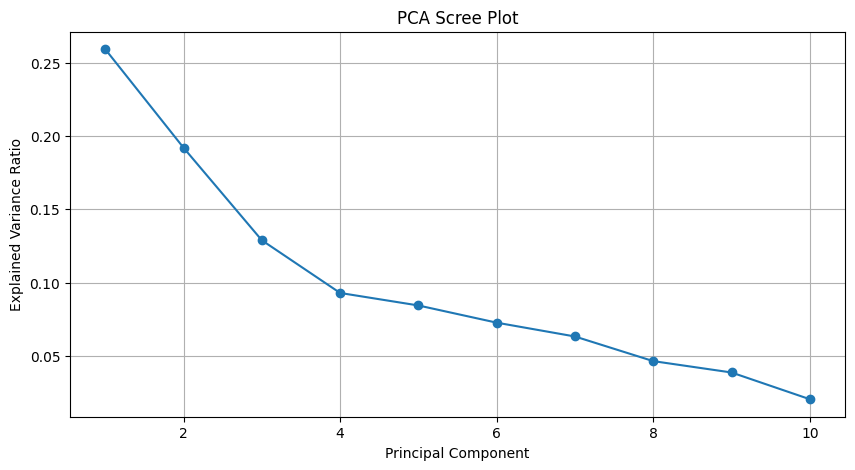

In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

In [15]:
# Fit PCA with 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(scaled_df)

df_pca2 = pd.DataFrame(pca_2_result, columns=["PC1", "PC2"])
df_pca2.head()

,PC1,PC2
0,-1.920474,0.733910
1,-1.471750,-1.590826
2,-0.358706,1.830716
3,-0.220312,1.458931
4,-2.478952,0.171847


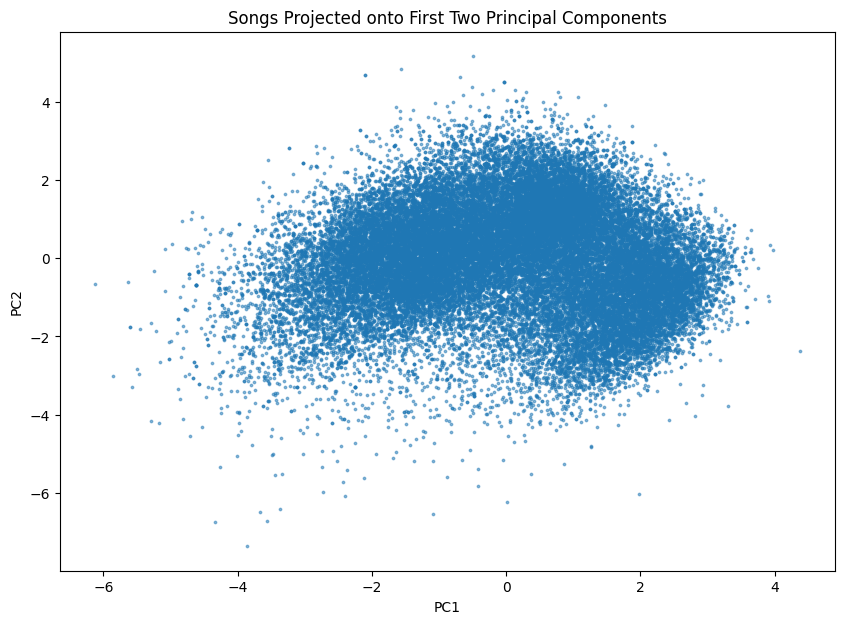

In [16]:
plt.figure(figsize=(10,7))
plt.scatter(df_pca2["PC1"], df_pca2["PC2"], s=3, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Songs Projected onto First Two Principal Components")
plt.show()

### 3. PCA Analysis

To better understand the underlying structure of the audio features, PCA 
(Principal Component Analysis) was applied to the scaled dataset. PCA serves two 
purposes: (1) reducing correlations among features, and (2) providing a 
low-dimensional space for visualization of clusters.

The scree plot shows that the first two principal components capture roughly 
**45%** of the total variance, and the first three components capture nearly 
**60%**. This indicates that a small number of components summarize a large 
portion of the dataset's variation, making PCA suitable for downstream cluster 
visualization.

The 2D PCA scatterplot reveals a continuous, roughly elliptical distribution of 
songs. Although the clusters are not sharply separated in raw feature space, the 
projection suggests that the dataset contains **several broad, overlapping 
musical regions**, which is consistent with real-world musical diversity. This 
structure motivates the use of clustering algorithms such as K-Means or Gaussian 
Mixture Models to identify high-level groups of songs based on their audio 
characteristics.

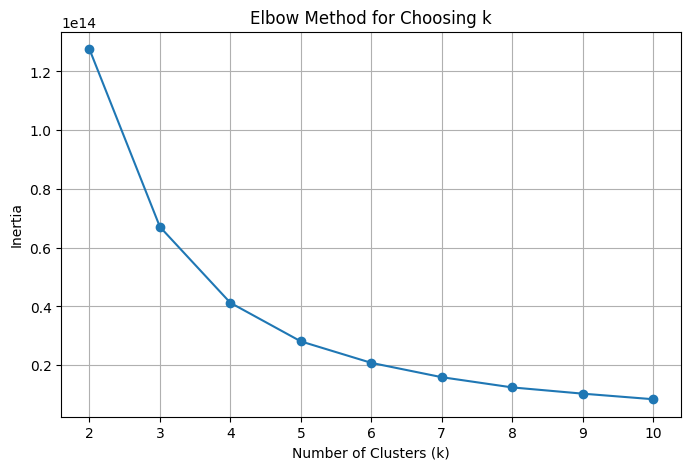

In [17]:
from sklearn.cluster import KMeans

inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_model)  # or scaled_df — we can compare both later
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing k")
plt.grid(True)
plt.show()

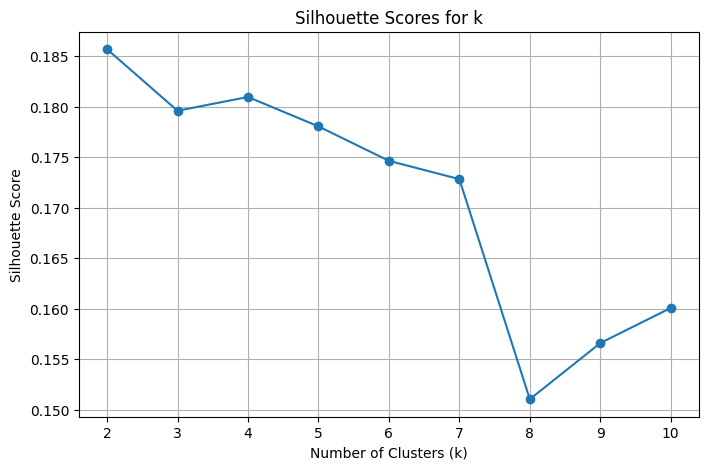

In [18]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)  # scaled is recommended for silhouette
    score = silhouette_score(scaled_df, labels)
    sil_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for k")
plt.grid(True)
plt.show()

### 4. Selecting the Number of Clusters

To determine an appropriate number of clusters for K-Means, both the **Elbow 
Method** and **Silhouette Analysis** were performed.

- The Elbow plot shows a clear point of diminishing returns at **k = 4**, where 
  inertia drops rapidly for k = 2–4 but flattens afterward.
- Silhouette scores indicate that **k = 2** technically produces the most compact 
  clusters, but such a small number of clusters would yield limited 
  interpretability for musical analysis.
- The Silhouette score for **k = 4** is the next-highest and balances good 
  separation with real-world interpretability.

Based on these results, **k = 4** was selected as the optimal number of clusters.
This configuration offers musically meaningful segmentation while maintaining 
robust internal cohesion.

In [19]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_df)

df_pca2['cluster'] = cluster_labels

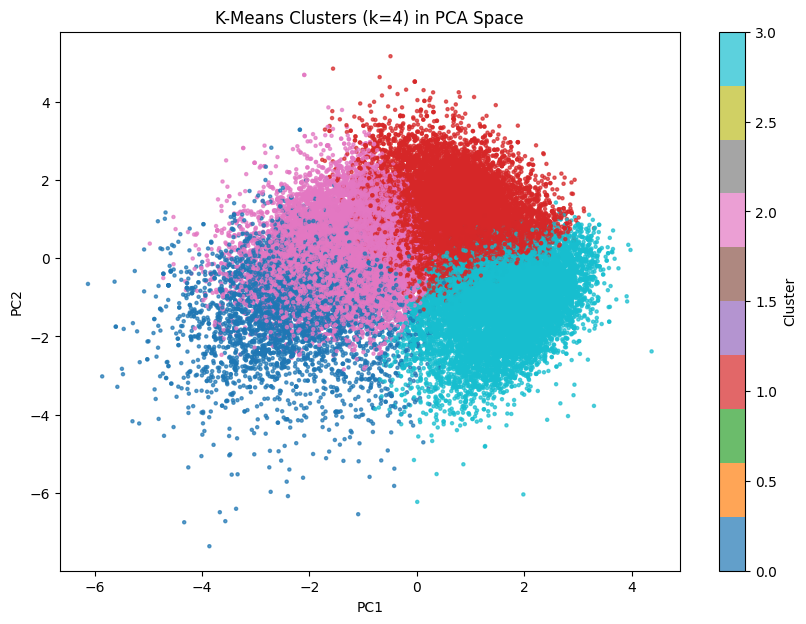

In [20]:
plt.figure(figsize=(10,7))
plt.scatter(df_pca2["PC1"], df_pca2["PC2"], 
            c=df_pca2["cluster"], cmap="tab10", s=5, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters (k=4) in PCA Space")
plt.colorbar(label="Cluster")
plt.show()

In [21]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_model.columns)
cluster_centers

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-0.025248,-1.525363,-1.112007,0.090953,2.235404,-0.467835,-0.324615,-0.159925,0.051085,-0.526825
1,-0.823038,0.634061,0.788071,-0.102232,-0.358245,-0.321145,0.378609,-0.306406,0.240647,-0.259541
2,0.781812,-0.507387,-0.092235,0.575859,0.010034,-0.673043,-0.195326,0.645674,0.123422,-0.560861
3,0.076238,0.431451,-0.398793,-0.587323,-0.454673,1.352453,-0.096477,-0.327963,-0.451187,1.170708


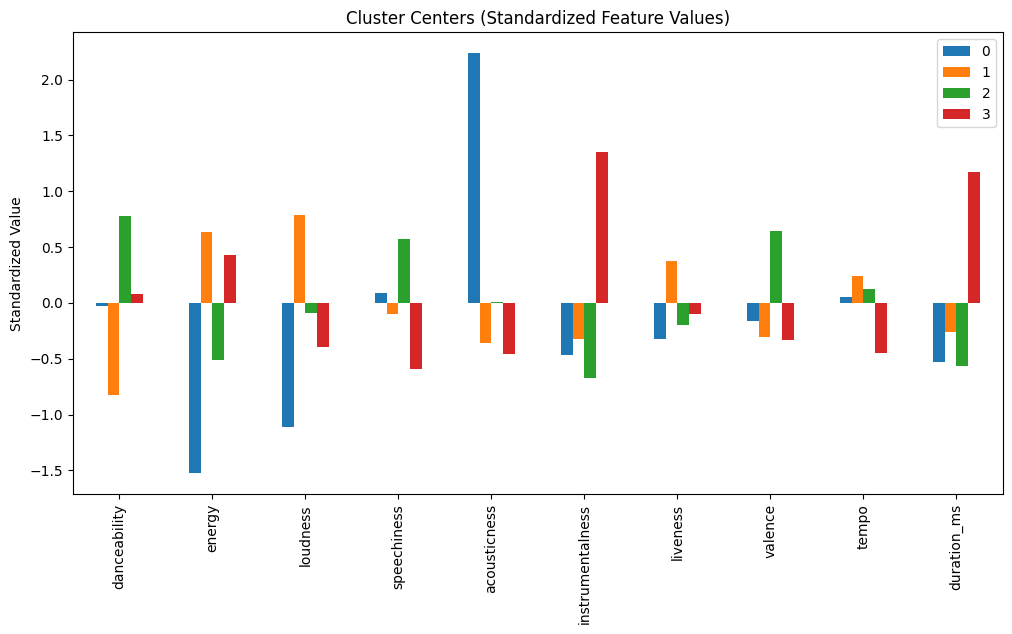

In [22]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_model.columns)
cluster_centers.T.plot(kind='bar', figsize=(12,6))
plt.title("Cluster Centers (Standardized Feature Values)")
plt.ylabel("Standardized Value")
plt.show()

### 5. Cluster Interpretation

After fitting K-Means with **k = 4**, the cluster centers were examined to 
understand the musical characteristics represented by each group. Since the 
features were standardized, positive values indicate above-average feature 
levels, and negative values indicate below-average levels.

#### **Cluster 0 — Acoustic / Mellow**
- Very low energy and loudness  
- Extremely high acousticness  
- Below-average instrumentalness and danceability  

This cluster represents quiet, mellow, and acoustic tracks such as soft indie, 
folk, and lo-fi acoustic music.

#### **Cluster 1 — Intense / Loud Rock-Pop**
- High energy and loudness  
- Low danceability  
- Low acousticness  
- Somewhat higher liveness  

This group captures energetic but non-dance-focused tracks such as rock, 
alternative, high-energy pop, and emotional ballads.

#### **Cluster 2 — Upbeat / Rhythmic / Danceable**
- Highest danceability  
- High valence (positive mood)  
- High speechiness  
- Near-average loudness and acousticness  

This cluster corresponds to upbeat, rhythmic music including dance-pop, R&B, 
rap, and groove-driven tracks.

#### **Cluster 3 — Instrumental / Ambient / Electronic**
- Very high instrumentalness  
- Long duration  
- Lower tempo  
- Low speechiness  

This cluster represents atmospheric, cinematic, and instrumental music, 
including ambient electronic, soundtracks, and long-form electronic genres.

### 6. Discussion and Conclusions

This project used unsupervised learning techniques to uncover structure within a 
large Spotify audio features dataset. PCA revealed that the majority of 
variation in the dataset can be captured by a small number of components, with 
PC1 reflecting an energy–acousticness axis and PC2 capturing 
speechiness–danceability characteristics.

K-Means clustering with **k = 4** uncovered four musically coherent groups:
1. Acoustic / mellow  
2. Intense, loud, high-energy rock-pop  
3. Upbeat, danceable, rhythmic tracks  
4. Instrumental / ambient / electronic  

These clusters align with intuitive musical categories and demonstrate how 
unsupervised learning can segment songs based purely on audio features without 
genre labels. 

Future extensions could include:
- Applying Gaussian Mixture Models for softer cluster boundaries  
- Using UMAP or t-SNE for nonlinear dimensionality reduction  
- Incorporating playlist-level metadata for personalized recommendations  

Overall, the project shows that unsupervised learning provides powerful tools for 
exploring high-dimensional audio data and identifying meaningful musical patterns.